# Read WFS data into Shapely/Cartopy

In [16]:
#github.com/nteract/papermill'parameters'tag used to inject them into template then post a gist runable by colab
url,ext,urn=None,None,None

# Parameters
# these parameters are passed from the GeoCodes Searth interface; 
# assign default values:
url = ""
ext = ""
urn = ""

In [2]:
# Python interface to PROJ (cartographic projections and coordinate transformations library).
# !pip show pyproj

Name: pyproj
Version: 3.2.1
Summary: Python interface to PROJ (cartographic projections and coordinate transformations library)
Home-page: https://github.com/pyproj4/pyproj
Author: Jeff Whitaker
Author-email: jeffrey.s.whitaker@noaa.gov
License: MIT
Location: c:\anaconda\envs\geocodes\lib\site-packages
Requires: certifi
Required-by: OWSLib, Cartopy


Based on notebook by Rich Signell. Use to test connection to GeoServer WFS with JSON output format

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import geojson
from owslib.wfs import WebFeatureService
from shapely.geometry import Polygon, Point, mapping, asShape, shape
# import cartopy.crs as ccrs
# from cartopy.io.img_tiles import MapQuestOpenAerial, MapQuestOSM, OSM
%matplotlib inline

In [4]:
# some WFS endpoints:
# hydro share wfs v2.0.0 'https://geoserver.hydroshare.org/geoserver/HS-c8427d7a30f0440b9773d17b7369fb69/wfs?service=wfs&version=2.0.0&request=GetCapabilities'

endpoint = 'https://geoserver.hydroshare.org/geoserver/HS-c8427d7a30f0440b9773d17b7369fb69/wfs'

#endpoint='https://www.sciencebase.gov/catalogMaps/mapping/ows/5342c54be4b0aa151574a8dc'
# endpoint='https://www.sciencebase.gov/catalogMaps/mapping/ows/5342c5fce4b0aa151574a8ed'
#endpoint='https://www.sciencebase.gov/catalogMaps/mapping/ows/5342e124e4b0aa151574a969'
wfs = WebFeatureService(endpoint)

print ("wfs version",wfs.version)

wfs version 1.0.0


In [5]:
shp = wfs.contents.keys()
print(shp)

dict_keys(['HS-c8427d7a30f0440b9773d17b7369fb69:watersheds'])


In [6]:
for akey in shp:
    a = wfs.contents[akey]
    b = a.boundingBoxWGS84
    print (b)

(-71.62501100293044, 18.92295794783721, -70.5133161089531, 19.76631219935061)


In [7]:
shp = filter(lambda a: a != 'sb:footprint', shp)
featurelist=list(shp)
print(featurelist)


['HS-c8427d7a30f0440b9773d17b7369fb69:watersheds']


In [8]:
def flip_geojson_coordinates(geo):
    if isinstance(geo, dict):
        for k in geo:
            #print("key: ",k)
            if k == "coordinates":
                z = np.asarray(geo[k])
                f = z.flatten()
                geo[k] = np.dstack((f[1::2], f[::2])).reshape(z.shape).tolist()
            else:
                flip_geojson_coordinates(geo[k])
    elif isinstance(geo, list):
        for k in geo:
            #print('list key {0}'.format(k))
            flip_geojson_coordinates(k)

In [9]:
#srs='EPSG:4326' # v1.0 syntax
srs='urn:x-ogc:def:crs:EPSG:4326'  # v1.1 syntax
json_response = wfs.getfeature(typename=[featurelist[0]], propertyname=None, srsname=srs, outputFormat='application/json').read()
#json_response = wfs.getfeature(typename=[next(shp)], propertyname=None, srsname=srs, outputFormat='application/json').read()

geo = geojson.loads(json_response)
print('JSON reponse loaded in geo object')
#flip_geojson_coordinates(geo) 
#print('flip done')

geo done


In [15]:
# print(geo.keys())
# print(geo['type'])

In [12]:
def image_spoof(self, tile): # this function pretends not to be a Python script
    #copied from from https://makersportal.com/blog/2020/4/24/geographic-visualizations-in-python-with-cartopy
    from urllib.request import urlopen, Request
    from PIL import Image
    url = self._image_url(tile) # get the url of the street map API
    req = Request(url) # start request
    req.add_header('User-agent','Anaconda 3') # add user agent to request
    fh = urlopen(req) 
    im_data = io.BytesIO(fh.read()) # get image
    fh.close() # close url
    img = Image.open(im_data) # open image with PIL
    img = img.convert(self.desired_tile_form) # set image format
    return img, self.tileextent(tile), 'lower' # reformat for cartopy

tiler crs  +proj=merc +a=6378137.0 +b=6378137.0 +nadgrids=@null +lon_0=0.0 +x_0=0.0 +y_0=0.0 +units=m +no_defs +type=crs
bounds from Shapely:  (-71.215788, 19.5108, -70.884481, 19.766312)
bounds from Shapely:  (-71.502504, 19.604819, -71.425118, 19.729431)
bounds from Shapely:  (-71.534492, 19.557172, -71.450448, 19.620952)
bounds from Shapely:  (-71.46387, 19.54281, -71.326805, 19.660827)
bounds from Shapely:  (-71.097692, 19.318548, -70.862716, 19.592679)
bounds from Shapely:  (-70.994576, 19.430626, -70.681227, 19.656814)
bounds from Shapely:  (-71.54681, 19.41671, -71.410937, 19.564248)
bounds from Shapely:  (-71.625011, 19.367718, -71.478566, 19.62528)
bounds from Shapely:  (-71.336284, 19.350828, -71.201965, 19.627203)
bounds from Shapely:  (-71.42167, 19.3028, -71.276161, 19.556808)
bounds from Shapely:  (-71.091765, 19.51321, -70.983365, 19.597816)
bounds from Shapely:  (-71.222282, 19.385847, -71.146035, 19.576698)
bounds from Shapely:  (-71.163921, 19.447452, -71.033858, 19.5

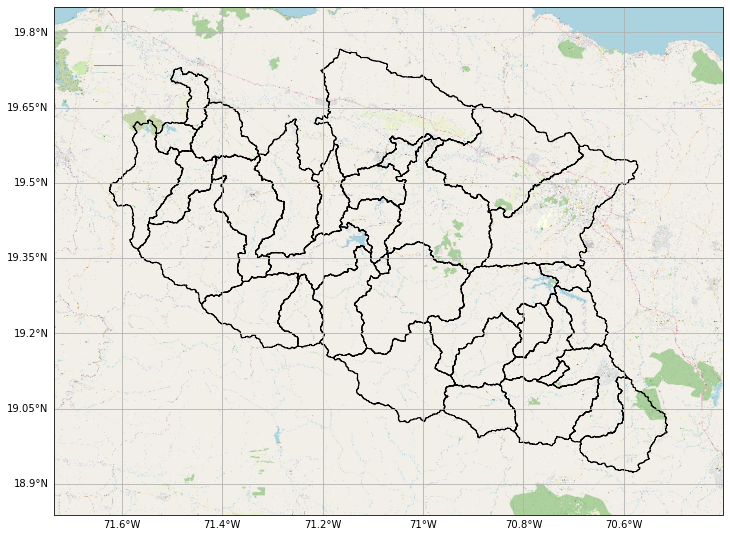

In [14]:
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import io


geodetic = ccrs.Geodetic(globe=ccrs.Globe(datum='WGS84'))

plt.figure(figsize=(12,12))
# Open Source Imagery from MapQuest (max zoom = 16?) [SMR2018-05-18 doesn't work]
#tiler = MapQuestOpenAerial()
# Open Street Map (max zoom = 18?)
# tiler = OSM()
cimgt.OSM.get_image = image_spoof # reformat web request for street map spoofing
tiler = cimgt.OSM() # spoofed, downloaded street map
# OSM projection is web mercator, meters
ax = plt.axes(projection=ccrs.PlateCarree())
print('tiler crs ', tiler.crs)
# b is the bounding box provided by the WFS service for the selected layer
dx=b[2]-b[0]
dy=b[3]-b[1]
extent = (b[0]-0.1*dx,b[2]+0.1*dx,b[1]-0.1*dy,b[3]+0.1*dy)
ax.set_extent(extent, ccrs.PlateCarree())
ax.add_image(tiler, 14)
#ax.add_geometries([polygon],ccrs.PlateCarree(),
#                          facecolor=BLUE, edgecolor=GRAY,alpha=0.5)
for p in geo.get("features", []):
    multi_poly = asShape(p.get("geometry"))
    print ('bounds from Shapely: ',multi_poly.bounds)
    #print ('multipoly:', multi_poly)
#    name=p['properties']['NAME']
#    print name
#ccrs.PlateCarree() , transform=tiler.crs
    ax.add_geometries(multi_poly, crs=ccrs.PlateCarree(), edgecolor='black',facecolor='none')
#title(name)
#, edgecolor='black',facecolor='none',hatch='/'
    
gl=ax.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
#ax.add_feature(coast_10m,edgecolor='black')
#ax.coastlines()
plt.show() # show the plot